### Supervised Learning >> Linear Models

This notebook containes examples from the scikit learn user guide: https://scikit-learn.org/stable/user_guide.html \
P.S. Hands down, this is a really great resources for diving into applied aspects of Machine Learning. 

Index: 
1. Generalized Linear Models
2. Ordinary Least Squares
3. Non Negative Least Squares
4. Ridge Regression
5. Ridge Coefficients as a function of regularization
6. GridSearchCV
7. Lasso Regression 
8. Bayesian Ridge Regression
9. Logistic Regression - Binary and Multinomial Case 
10. Polynomial Regression, XOR with Linear Classifier
   
Additional Topics:
1. Pipeline | Chaining pre-processors & estimators
2. Automatic Parameter Search | RandomizedSearchCV

In [ ]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 12px;
</style>

<b>Generalized Linear Models</b> \
TweedieRegressor implements a generalized linear model for the Tweedie distribution:
1. power = 0 Normal Distribution; Specific estimators such as Ridge, ElasticNet are more apt for this case
2. power = 1 Poisson Distribution; PoissonRegressor is exposed for convenience which is strictly equivalent to TweedieRegressor(power=1, link='log')
3. power = 2 Gamma Distribution; GammaRegressor is exposed for convenience which is strictly equivalent to TweedieRegressor(power=2, link='log')
4. power = 3 Inverse Gaussian distribution

The link function is determined by the link parameter.

In [1]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.5, link='log')
reg.fit([[0, 0], [0, 1], [2, 2]], [0, 1, 2]), reg.coef_, reg.intercept_

(TweedieRegressor(alpha=0.5, link='log', power=1),
 array([0.24631611, 0.43370317]),
 -0.7638091359123443)

When performing cross-validation for the power parameter of TweedieRegressor, it is advisable to specify an explicit scoring function, because the default scorer TweedieRegressor.score is a function of power itself.

<b>Ordinary Least Squares</b>

In [2]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2]), reg.coef_

(LinearRegression(), array([0.5, 0.5]))

The coefficient estimates for Ordinary Least Squares rely on the independence of the features. When features are correlated and the columns of the design matrix have an approximately linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

<b>Non Negative Least Squares</b>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Generating some random data

np.random.seed(42)
n_samples, n_features = 200, 50
X = np.random.randn(n_samples, n_features)
true_coef = 3 * np.random.randn(n_features)
true_coef[true_coef < 0] = 0 # Threshold coefficients to render them non-negative
y = np.dot(X, true_coef)
y += 5 * np.random.normal(size=(n_samples,)) # Add some noise

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# NNLS 
from sklearn.linear_model import LinearRegression
reg_nnls = LinearRegression(positive=True)
y_pred_nnls = reg_nnls.fit(X_train, y_train).predict(X_test)
r2_score_nnls = r2_score(y_test, y_pred_nnls)
print("NNLS R2 score", r2_score_nnls)

# OLS
reg_ols = LinearRegression()
y_pred_ols = reg_ols.fit(X_train, y_train).predict(X_test)
r2_score_ols = r2_score(y_test, y_pred_ols)
print("OLS R2 score", r2_score_ols)

NNLS R2 score 0.8225220806196526
OLS R2 score 0.7436926291700352


Comparing the regression coefficients between OLS and NNLS, we can observe they are highly correlated, but the non-negative constraint shrinks some to 0. The Non-Negative Least squares inherently yield sparse results.

<b>Ridge Regression</b>

In [5]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1]), reg.coef_, reg.intercept_

(Ridge(alpha=0.5), array([0.34545455, 0.34545455]), 0.13636363636363638)

Note that the class Ridge allows for the user to specify that the solver be automatically chosen by setting solver="auto". When this option is specified, Ridge will choose between the "lbfgs", "cholesky", and "sparse_cg" solvers. Ridge will begin checking the conditions shown in the following table from top to bottom. If the condition is true, the corresponding solver is chosen.

Solver | Condition \
‘lbfgs’ --> The positive=True option is specified. \
‘cholesky’ --> The input array X is not sparse. \
‘sparse_cg’ --> None of the above conditions are fulfilled.

<b>Ridge Coefficients as a function of regularization</b>\
This example also shows the usefulness of applying Ridge regression to highly ill-conditioned matrices. For such matrices, a slight change in the target variable can cause huge variances in the calculated weights. In such cases, it is useful to set a certain regularization (alpha) to reduce this variation (noise).

When alpha is very large, the regularization effect dominates the squared loss function and the coefficients tend to zero. At the end of the path, as alpha tends toward zero and the solution tends towards the ordinary least squares, coefficients exhibit big oscillations. In practise it is necessary to tune alpha in such a way that a balance is maintained between both.

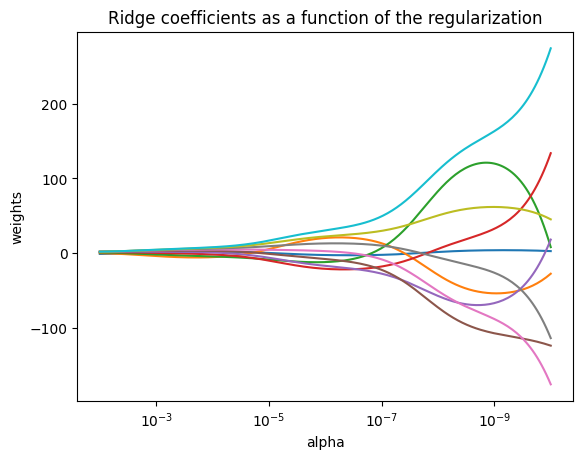

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

X = 1.0 / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis]) # X is the 10x10 Hilbert matrix
y = np.ones(10)

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

<b>Setting the regularization parameter: leave-one-out Cross-Validation</b> \
RidgeCV implements ridge regression with built-in cross-validation of the alpha parameter. The object works in the same way as GridSearchCV except that it defaults to Leave-One-Out Cross-Validation:

In [7]:
import numpy as np
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1]), reg.alpha_

(RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])),
 0.01)

Specifying the value of the cv attribute will trigger the use of cross-validation with GridSearchCV, for example cv=10 for 10-fold cross-validation, rather than Leave-One-Out Cross-Validation.

<b>GridSearchCV</b>

In [10]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

<b>Lasso Regression</b> \
The implementation in the class Lasso uses coordinate descent as the algorithm to fit the coefficients. 

In [11]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit([[0, 0], [1, 1]], [0, 1]), reg.predict([[1, 1]])

(Lasso(alpha=0.1), array([0.8]))

The function lasso_path is useful for lower-level tasks, as it computes the coefficients along the full path of possible values. 

As the Lasso regression yields sparse models, it can thus be used to perform feature selection [L1-based feature selection]

The alpha parameter controls the degree of sparsity of the estimated coefficients. scikit-learn exposes objects that set the Lasso alpha parameter by cross-validation: <b>LassoCV</b> and <b>LassoLarsCV</b>. LassoLarsCV is based on the Least Angle Regression. For high-dimensional datasets with many collinear features, LassoCV is most often preferable. However, LassoLarsCV has the advantage of exploring more relevant values of alpha parameter, and if the number of samples is very small compared to the number of features, it is often faster than LassoCV.

Alternatively, the estimator <b>LassoLarsIC</b> proposes to use the Akaike information criterion (AIC) and the Bayes Information criterion (BIC). It is a computationally cheaper alternative to find the optimal value of alpha as the regularization path is computed only once instead of k+1 times when using k-fold cross-validation.

<b>LassoLars</b>

In [5]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=.1)
reg.fit([[0, 0], [1, 1]], [0, 1]), reg.coef_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


(LassoLars(alpha=0.1), array([0.71715729, 0.        ]))

The Lars algorithm provides the full path of the coefficients along the regularization parameter almost for free, thus a common operation is to retrieve the path with one of the functions lars_path or lars_path_gram.

In [7]:
reg.coef_path_

array([[0.        , 0.50710678],
       [0.        , 0.        ]])

<b>Bayesian Ridge Regression</b>

In [11]:
from sklearn import linear_model
X = [[0., 0.], [1., 1.], [2., 2.], [3., 3.]]
Y = [0., 1., 2., 3.]
reg = linear_model.BayesianRidge()
reg.fit(X, Y), reg.predict([[1, 0.]]), reg.coef_

(BayesianRidge(), array([0.50000013]), array([0.49999993, 0.49999993]))

Due to the Bayesian framework, the weights found are slightly different to the ones found by Ordinary Least Squares. However, Bayesian Ridge Regression is more robust to ill-posed problems.

<b>Logistic Regression - Binary and Multinomial Case</b> \
The predict_proba method of LogisticRegression predicts the probability of the positive class P(Yi = 1 | Xi). 

There might be a difference in the scores obtained between LogisticRegression with solver=liblinear or LinearSVC and the external liblinear library directly, when fit_intercept=False and the fit coef_ (or) the data to be predicted are zeroes. This is because for the sample(s) with decision_function zero, LogisticRegression and LinearSVC predict the negative class, while liblinear predicts the positive class. Note that a model with fit_intercept=False and having many samples with decision_function zero, is likely to be a underfit, bad model and you are advised to set fit_intercept=True and increase the intercept_scaling.

A logistic regression with l1 penalty yields sparse models, and can thus be used to perform feature selection, as detailed in L1-based feature selection.

It is possible to obtain the p-values and confidence intervals for coefficients in cases of regression without penalization. The statsmodels package natively supports this. Within sklearn, one could use bootstrapping instead as well.

LogisticRegressionCV implements Logistic Regression with built-in cross-validation support, to find the optimal C and l1_ratio parameters according to the scoring attribute. The “newton-cg”, “sag”, “saga” and “lbfgs” solvers are found to be faster for high-dimensional dense data, due to warm-starting

In [13]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X[:2, :]), clf.predict_proba(X[:2, :]), clf.score(X, y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([0, 0]),
 array([[9.81799410e-01, 1.82005761e-02, 1.43509290e-08],
        [9.71722782e-01, 2.82771875e-02, 3.00214336e-08]]),
 0.9733333333333334)

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)

<b>Polynomial Regression</b>

In [2]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [3]:
poly = PolynomialFeatures(degree = 2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

PolynomialFeatures is a transformer which transforms an input data matrix into a new data matrix of a given degree. 

The features of X have been transformed from [x1, x2] to [1, x1, x2, x1^2, x1x2, x2_2] and cannow be used with any linear model. This sort of preprocessing can be streamlined with the Pipeline tools. A single object representing a simple polynomial regression can be created and used as follows:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree = 3)), 
                        ('linear', LinearRegression(fit_intercept = False))])

x = np.arange(5)
y = 3 - 2*x + x**2 - x**3
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_

array([ 3., -2.,  1., -1.])

The linear model trained on polynomial features is able to exactly recover the input polynomial coefficients. 

In some cases it’s not necessary to include higher powers of any single feature, but only the so-called interaction features that multiply together at most distinct features. These can be gotten from PolynomialFeatures with the setting interaction_only=True. 

For example, when dealing with boolean features,xi^n = xi for all n and is therefore useless; but xixj represents the conjunction of two booleans. This way, we can solve the <b>XOR problem with a linear classifier</b>:

In [8]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = X[:, 0]^X[:, 1]
y

array([0, 1, 1, 0])

In [9]:
X = PolynomialFeatures(interaction_only = True).fit_transform(X).astype(int)
X

array([[1, 0, 0, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 1]])

In [11]:
clf = Perceptron(fit_intercept = False, 
                    max_iter = 10, tol = None, shuffle = False).fit(X, y)
clf.predict(X)

array([0, 1, 1, 0])

In [12]:
clf.score(X, y)

1.0

Score of 1 indicates that the classifier predictions are perfect. 

#### Pipeline | Chaining pre-processors & estimators

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# creating the pipeline object
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# working with the iris dataset/
X, y = load_iris(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# fitting the pipeline
pipe.fit(X_train, y_train)

# usable as any other estimator
accuracy_score(pipe.predict(X_test), y_test)

0.9736842105263158

#### Automatic Parameter Search | RandomizedSearchCV

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint

X, y = fetch_california_housing(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# define parameter space that will be searched over
param_distributions = {'n_estimators': randint(1, 5), 
                              'max_depth': randint(5, 10)}

# creating searchCV object for fitting to the data
search = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=0),
                     n_iter=5, param_distributions=param_distributions,
                        random_state=0)

search.fit(X_train, y_train)
search.best_params_

{'max_depth': 9, 'n_estimators': 4}

In [4]:
search.score(X_test, y_test)

0.735363411343253

<b>The End</b>